<a href="https://colab.research.google.com/github/akumuyi/linear_regression_model/blob/main/multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load and Preprocess the Dataset
First, we need to load the dataset into a pandas DataFrame, ensure it's sorted by date (since it's time-series data), and prepare features and the target variable.

In [40]:
import pandas as pd
import numpy as np

# Load the dataset (assuming it's in a file; adjust if loading from string)
df = pd.read_csv('/content/drive/MyDrive/Machine_Learning_Summative/summative2/EURUSD_D1.csv', parse_dates=['Date'])

# Sort by date to ensure chronological order
df = df.sort_values('Date')

# Define the window size for lagged features
N = 5

# Create lagged features for Open, High, Low, Close, and Volume
for i in range(1, N + 1):
    df[f'Open_lag{i}'] = df['Open'].shift(i)
    df[f'High_lag{i}'] = df['High'].shift(i)
    df[f'Low_lag{i}'] = df['Low'].shift(i)
    df[f'Close_lag{i}'] = df['Close'].shift(i)
    df[f'Volume_lag{i}'] = df['Volume'].shift(i)

# Create the target variable: next day's closing price
df['Target'] = df['Close'].shift(-1)

# Drop rows with NaN values (first N rows lack full lagged features, last row lacks target)
df = df.dropna()

# Define feature columns
feature_cols = [f'{var}_lag{i}' for var in ['Open', 'High', 'Low', 'Close', 'Volume'] for i in range(1, N + 1)]

In [41]:
df.head()

,Date,Open,High,Low,Close,Volume,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,Open_lag4,High_lag4,Low_lag4,Close_lag4,Volume_lag4,Open_lag5,High_lag5,Low_lag5,Close_lag5,Volume_lag5,Target
5,2009-03-17,1.29730,1.30410,1.29300,1.30320,767922,1.28810,1.30710,1.28670,1.29740,1113781.0,1.28791,1.28940,1.28375,1.28805,26991.0,1.28970,1.29570,1.28620,1.29280,812346.0,1.28050,1.29445,1.27315,1.28970,1032092.0,1.27605,1.28645,1.27430,1.28050,631410.0,1.34870
6,2009-03-18,1.30315,1.35345,1.29860,1.34870,979564,1.29730,1.30410,1.29300,1.30320,767922.0,1.28810,1.30710,1.28670,1.29740,1113781.0,1.28791,1.28940,1.28375,1.28805,26991.0,1.28970,1.29570,1.28620,1.29280,812346.0,1.28050,1.29445,1.27315,1.28970,1032092.0,1.36595
7,2009-03-19,1.34865,1.37375,1.34165,1.36595,973663,1.30315,1.35345,1.29860,1.34870,979564.0,1.29730,1.30410,1.29300,1.30320,767922.0,1.28810,1.30710,1.28670,1.29740,1113781.0,1.28791,1.28940,1.28375,1.28805,26991.0,1.28970,1.29570,1.28620,1.29280,812346.0,1.35795
8,2009-03-20,1.36595,1.37260,1.35170,1.35795,825191,1.34865,1.37375,1.34165,1.36595,973663.0,1.30315,1.35345,1.29860,1.34870,979564.0,1.29730,1.30410,1.29300,1.30320,767922.0,1.28810,1.30710,1.28670,1.29740,1113781.0,1.28791,1.28940,1.28375,1.28805,26991.0,1.36265
9,2009-03-22,1.36200,1.36740,1.36173,1.36265,47969,1.36595,1.37260,1.35170,1.35795,825191.0,1.34865,1.37375,1.34165,1.36595,973663.0,1.30315,1.35345,1.29860,1.34870,979564.0,1.29730,1.30410,1.29300,1.30320,767922.0,1.28810,1.30710,1.28670,1.29740,1113781.0,1.36175


# Step 2: Split the Data
Since this is time-series data, we'll split it chronologically rather than randomly to prevent look-ahead bias. We'll use data before 2020-01-01 for training and after for testing (approximately 68% train, 32% test based on the date range from 2009 to 2025).

In [42]:
# Split into training and testing sets
train = df[df['Date'] < '2020-01-01']
test = df[df['Date'] >= '2020-01-01']

X_train = train[feature_cols]
y_train = train['Target']
X_test = test[feature_cols]
y_test = test['Target']

# Step 3: Standardize the Features
Linear regression benefits from standardized features, especially since Volume is on a different scale than price data.

In [43]:
from sklearn.preprocessing import StandardScaler

# Initialize and fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train Linear Regression with Gradient Descent
We'll use SGDRegressor from scikit-learn, which implements linear regression with stochastic gradient descent (SGD). We'll train it in a loop to track the loss (mean squared error, MSE) over epochs for both training and testing data.

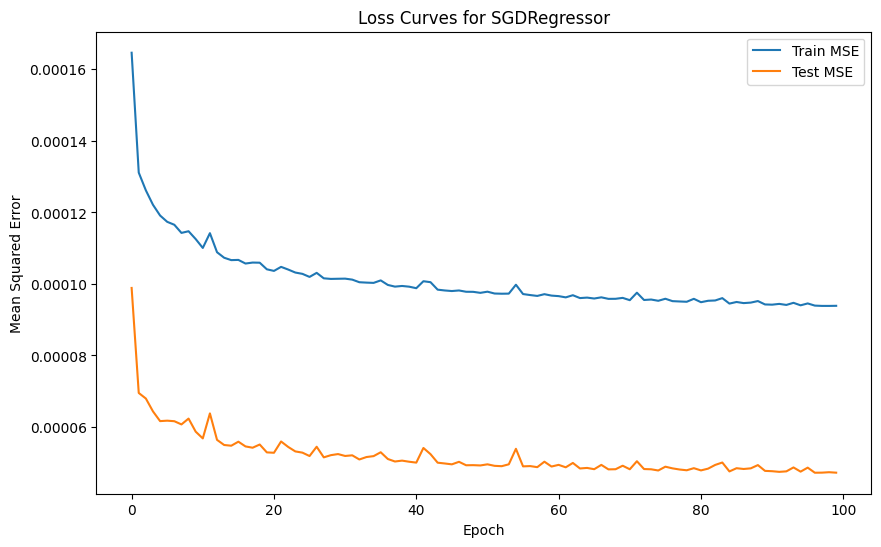

SGDRegressor Test MSE: 0.000047


In [44]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Initialize SGDRegressor
model = SGDRegressor(loss='squared_error', max_iter=1, warm_start=True, shuffle=False, random_state=42)

# Training loop parameters
num_epochs = 100
batch_size = 32
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    # Shuffle training data manually for each epoch
    indices = np.random.permutation(len(X_train_scaled))
    X_train_shuffled = X_train_scaled[indices]
    y_train_shuffled = y_train.values[indices]  # Convert to numpy array

    # Mini-batch training
    for i in range(0, len(X_train_scaled), batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]
        model.partial_fit(X_batch, y_batch)

    # Compute MSE after each epoch
    y_train_pred = model.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_losses.append(train_mse)

    y_test_pred = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_losses.append(test_mse)

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train MSE')
plt.plot(range(num_epochs), test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Loss Curves for SGDRegressor')
plt.legend()
plt.show()

# Final evaluation
sgd_test_mse = test_losses[-1]
print(f"SGDRegressor Test MSE: {sgd_test_mse:.6f}")

# Step 5: Compare with Decision Trees and Random Forests
Now, we'll train a decision tree and a random forest model using default parameters for comparison, evaluating all three models with MSE.

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_y_pred = dt_model.predict(X_test_scaled)
dt_test_mse = mean_squared_error(y_test, dt_y_pred)
print(f"DecisionTreeRegressor Test MSE: {dt_test_mse:.6f}")

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)
rf_test_mse = mean_squared_error(y_test, rf_y_pred)
print(f"RandomForestRegressor Test MSE: {rf_test_mse:.6f}")

# Compare all models
print("\nModel Comparison (Test MSE):")
print(f"SGDRegressor: {sgd_test_mse:.6f}")
print(f"DecisionTreeRegressor: {dt_test_mse:.6f}")
print(f"RandomForestRegressor: {rf_test_mse:.6f}")

DecisionTreeRegressor Test MSE: 0.000274
RandomForestRegressor Test MSE: 0.000228

Model Comparison (Test MSE):
SGDRegressor: 0.000047
DecisionTreeRegressor: 0.000274
RandomForestRegressor: 0.000228


# Step 6: Select and Save the Best Model
We'll identify the model with the lowest test MSE and save it along with the scaler for future use.

In [46]:
from joblib import dump

# Determine the best model
models = {
    'SGDRegressor': (model, sgd_test_mse),
    'DecisionTreeRegressor': (dt_model, dt_test_mse),
    'RandomForestRegressor': (rf_model, rf_test_mse)
}
best_model_name, (best_model, best_mse) = min(models.items(), key=lambda x: x[1][1])
print(f"\nBest Model: {best_model_name} with Test MSE: {best_mse:.6f}")

# Save the best model and scaler
dump(best_model, 'best_model.joblib')
dump(scaler, 'scaler.joblib')


Best Model: SGDRegressor with Test MSE: 0.000047


['scaler.joblib']